# MCMC & Variational Inference for Bayesian Data Analysis

Conducting a Bayesian data analysis - e.g. estimating a Bayesian linear regression model - will usually require some form of Probabilistic Programming Language (PPL), unless analytical approaches (e.g. based on conjugate prior models), are appropriate for the task at hand. More often than not, PPLs implement Markov Chain Monte Carlo (MCMC) algorithms that allow one to draw samples and make inferences from the posterior distribution implied by the choice of model - the likelihood and prior distributions for its parameters - conditional on the observed data.

MCMC algorithms are, generally speaking, computationally expensive and do not scale very easily. For example, it is not as easy to distribute the execution of these algorithms over a cluster of machines, when compared to the optimisation algorithms used for training deep neural networks (e.g. stochastic gradient descent).

Over the past few years, however, a new class of algorithms for inferring Bayesian models has been developed, that do **not** rely heavily on computationally expensive random sampling. These algorithms are referred to as Variational Inference (VI) algorithms and have been shown to be successful with the potential to scale to 'large' datasets.

My preferred PPL is [PYMC3](https://docs.pymc.io) and offers a choice of both MCMC and VI algorithms for inferring models in Bayesian data analysis. The purpose of this notebook is to demonstrate how they can both be used to perform a simple linear regression, and to then compare their results.

## A (very) Quick Introduction to Bayesian Data Analysis

Like statistical data analysis more broadly, the main aim of Bayesian Data Analysis (BDA) is to infer unknown parameters for models of observed data, in order to test hypotheses about the physical processes that lead to the observations. Bayesian data analysis deviates from traditional statistics - on a practical level - when it comes to the explicit assimilation of prior knowledge regarding the uncertainty of the model parameters, into the statistical inference process and overall analysis workflow. To this end, BDA focuses on the posterior distribution,

$$
p(\Theta | X) = \frac{p(X | \Theta) \cdot p(\Theta)}{p(X)}
$$

Where,

- $\Theta$ is the vector of unknown model parameters, that we wish to estimate; 
- $X$ is the vector of observed data;
- $p(X | \Theta)$ is the likelihood function that models the probability of observing the data for a fixed choice of parameters; and,
- $p(\Theta)$ is the prior distribution of the model parameters.

For an **excellent** (inspirational) introduction to practical BDA, take a look at [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/), or for a more theoetical treatment try [Bayesian Data Analysis by Gelman & co.](http://www.stat.columbia.edu/~gelman/book/).

This notebook is concerned with demonstrating and comparing two separate approaches for inferring the posterior distribution, $p(\Theta | X)$, for a linear regression model.

## Imports and Global Settings

Before we get going in earnest, we follow the convention of declaring all imports at the top of the notebook.

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano
import warnings
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split

from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from hpd import *




Bad key "text.kerning_factor" on line 4 in
C:\Anaconda2\envs\rdkit-env-3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


And then notebook-wide (global) settings that enable in-line plotting, configure Seaborn for visualisation and to explicitly ignore warnings (e.g. NumPy deprecations).

In [2]:
%matplotlib inline

sns.set()
warnings.filterwarnings('ignore')

## Create Synthetic Data

We will assume that there is a dependent variable (or labelled data) $\tilde{y}$, that is a linear function of independent variables (or feature data), $x$ and $c$. In this instance, $x$ is a positive real number and $c$ denotes membership to one of two categories that occur with equal likelihood. We express this model mathematically, as follows,

$$
\tilde{y} = \alpha_{c} + \beta_{c} \cdot x + \sigma \cdot \tilde{\epsilon}
$$

where $\tilde{\epsilon} \sim N(0, 1)$, $\sigma$ is the standard deviation of the noise in the data and $c \in \{0, 1\}$ denotes the category. We start by defining our *a priori* choices for the model parameters.

In [3]:

fname = "Random"  # file name for saved graphs
# Generate random data.
# True parameter values:
beta_true = np.repeat(0, 21)
beta_true = np.insert(beta_true, [0,0,0], [100, 10, 2])  # beta0 is first component
print("beta_true",beta_true,"\n\n")
n_predictors = len(beta_true) - 1
sd_true = 2
tau_true = 1/sd_true**2

# Random X values:
np.random.seed(47405)
xM = 5
xSD = 2
nData = 100
x = norm.rvs(xM, xSD, n_predictors*nData).reshape(100, -1)
print("norm.rvs generated x",x,"\n\n")
x = pd.DataFrame(x, columns=['X%s' % i for i in range(0, n_predictors)])
print("dataframe x",x,"\n\n")

# Random Y values generated from linear model with true parameter values:
y = np.sum(x * beta_true[1:].T, axis=1) + beta_true[0] + norm.rvs(0, sd_true, nData)
print("dataframe y",y,"\n\n")

# Select which predictors to include
includeOnly = range(0, n_predictors) # default is to include all
#x = x.iloc[includeOnly]
predictorNames = x.columns
n_predictors = len(predictorNames)




beta_true [100  10   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0] 


norm.rvs generated x [[ 3.87741636  5.00378642  3.40097651 ...  4.10058474  6.18801704
   2.30516983]
 [ 6.01782767  4.05148343  3.27001977 ...  3.99523275  3.04035615
   9.37601408]
 [ 7.00591002  1.81710924  3.18149778 ...  3.33315064  7.28323408
   3.93160154]
 ...
 [ 4.76407846  7.31045294  1.81138449 ...  3.26999075  4.86095223
   5.6747902 ]
 [ 4.86272388  3.05314855  5.8978431  ...  2.30448541 -0.18293265
   2.46834037]
 [ 3.72720664  7.08286148  6.45634587 ...  4.71056042  4.94214839
   2.01487115]] 


dataframe x           X0        X1        X2        X3        X4        X5        X6  \
0   3.877416  5.003786  3.400977  8.876203  5.931349  3.214358  6.306189   
1   6.017828  4.051483  3.270020  8.036151  3.069918  2.562163  5.806857   
2   7.005910  1.817109  3.181498  6.300537  7.259278  7.457281  4.817921   
3   7.440025  4.485406  5.938309  3.224499  4.577774  2.

We then use these to generate some random samples that we store in a DataFrame and visualise using the Seaborn package.

          X0        X1        X2        X3        X4        X5        X6  \
0   3.877416  5.003786  3.400977  8.876203  5.931349  3.214358  6.306189   
1   6.017828  4.051483  3.270020  8.036151  3.069918  2.562163  5.806857   
2   7.005910  1.817109  3.181498  6.300537  7.259278  7.457281  4.817921   
3   7.440025  4.485406  5.938309  3.224499  4.577774  2.350805  5.495704   
4   3.170378  5.295669  2.843190  5.705543  3.054070  7.298734  6.303862   
..       ...       ...       ...       ...       ...       ...       ...   
95  6.827474  8.069229  3.155421  5.379818  9.879944  5.737684  4.754505   
96  4.006508  1.526848  2.957328  6.368525  2.473683  4.311321  5.462404   
97  4.764078  7.310453  1.811384  4.666646  1.124313  8.387747  5.681830   
98  4.862724  3.053149  5.897843  7.419578  4.871653  5.674087  6.589367   
99  3.727207  7.082861  6.456346  7.264594  2.869492  6.097319  2.638908   

          X7        X8        X9  ...       X14       X15       X16       X17  \
0   4.

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,y
0,3.877416,5.003786,3.400977,8.876203,5.931349,3.214358,6.306189,4.412913,8.145601,5.035742,...,5.532214,3.227555,2.828645,8.123449,4.714151,6.215775,4.100585,6.188017,2.305170,148.249379
1,6.017828,4.051483,3.270020,8.036151,3.069918,2.562163,5.806857,2.448511,6.472247,5.791340,...,8.368445,2.734105,5.641064,4.897578,5.206008,4.760859,3.995233,3.040356,9.376014,168.671436
2,7.005910,1.817109,3.181498,6.300537,7.259278,7.457281,4.817921,7.283436,4.303056,4.120775,...,2.856851,1.892404,5.403830,2.730442,2.940290,6.240232,3.333151,7.283234,3.931602,172.586482
3,7.440025,4.485406,5.938309,3.224499,4.577774,2.350805,5.495704,5.570185,2.946123,5.638401,...,4.299603,3.999142,8.693932,4.033916,4.735150,5.203722,6.332033,2.382867,2.915401,182.664056
4,3.170378,5.295669,2.843190,5.705543,3.054070,7.298734,6.303862,7.072680,6.323182,4.605160,...,7.736707,4.248609,3.405464,1.862865,7.976783,2.708888,5.192746,0.095598,3.901626,140.670328


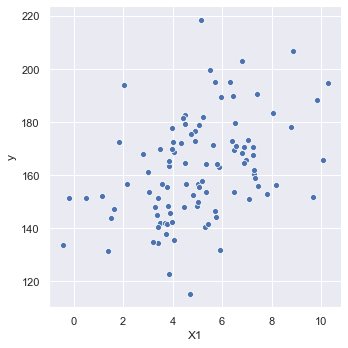

In [4]:
model_data=x.copy()
df_y=y.copy()
df_y.columns=["y"]
model_data["y"]=df_y

print(model_data)

display(model_data.head())
_ = sns.relplot(x='X1', y='y', data=model_data)






## Split Data into Training and Test Sets

One of the advantages of generating synthetic data is that we can ensure we have enough data to be able to partition it into two sets - one for training models and one for testing models. We use a helper function from the Scikit-Learn package for this task and make use of stratified sampling to ensure that we have a balanced representation of each category in both training and test datasets.

In [5]:
train, test = train_test_split(
    model_data, test_size=0.2)
x_train=train.drop(["y"],axis=1)
x_test=test.drop(["y"],axis=1)

We will be using the [PYMC3](https://docs.pymc.io) package for building and estimating our Bayesian regression models, which in-turn uses the Theano package as a computational 'back-end' (in much the same way that the Keras package for deep learning uses TensorFlow as back-end). Consequently, we will have to interact with Theano if we want to have the ability to swap between training and test data (which we do). As such, we will explicitly define 'shared' tensors for all of our model variables.

In [6]:
y_tensor = theano.shared(train.y.values.astype('float64'))
x_tensor = theano.shared(x_train.values.astype('float64'))
print(x_tensor)
#cat_tensor = theano.shared(train.category.values.astype('int64'))

<TensorType(float64, matrix)>


## Define Bayesian Regression Model

Now we move on to define the model that we want to estimate (i.e. our hypothesis regarding the data), irrespective of how we will perform the inference. We will assume full knowledge of the data-generating model we defined above and define conservative regularising priors for each of the model parameters.

In [7]:
with pm.Model() as model:
    '''
    alpha_prior = pm.HalfNormal('alpha', sd=2, shape=2)
    beta_prior = pm.Normal('beta', mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfNormal('sigma', sd=2, shape=1)
    mu_likelihood = alpha_prior[cat_tensor] + beta_prior[cat_tensor] * x_tensor
    y_likelihood = pm.Normal('y', mu=mu_likelihood, sd=sigma_prior, observed=y_tensor)
    '''
    # define the priors
    beta0 = pm.Normal('beta0', mu=0, sd=100)
    beta1 = pm.Normal('beta1', mu= 0, sd=100, shape=n_predictors)
    sd = pm.HalfNormal('sd', 25)
    mu = beta0 + pm.math.dot(beta1, x_tensor.T)
    # define the likelihood
    yl = pm.Normal('yl', mu, sd, observed=y_tensor)
    

## Model Inference Using MCMC (HMC)

We will make use of the default MCMC method in PYMC3's `sample` function, which is Hamiltonian Monte Carlo (HMC). Those interested in the precise details of the HMC algorithm are directed to the [excellent paper Michael Betancourt](https://arxiv.org/abs/1701.02434). Briefly, MCMC algorithms work by defining multi-dimensional Markovian stochastic processes, that when simulated (using Monte Carlo methods), will eventually converge to a state where successive simulations will be equivalent to drawing random samples from the posterior distribution of the model we wish to estimate.

The posterior distribution has one dimension for each model parameter, so we can then use the distribution of samples for each parameter to infer the range of possible values and/or compute point estimates (e.g. by taking the mean of all samples).

For the purposes of this demonstration, we sample two chains in parallel (as we have two CPU cores available for doing so and this effectively doubles the number of samples), allow 1,000 steps for each chain to converge to its steady-state and then sample for a further 5,000 steps - i.e. generate 5,000 samples from the posterior distribution, assuming that the chain has converged after 1,000 samples.

In [8]:
# Generate a MCMC chain
with model:
    hmc_trace = pm.sample(draws=5000, tune=1000, cores=4)
    #trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta1, beta0]
Sampling 4 chains, 3 divergences: 100%|██████████| 24000/24000 [00:57<00:00, 419.39draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Now let's take a look at what we can infer from the HMC samples of the posterior distribution.

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,102.268,3.092,96.340,108.033,0.028,0.020,11986.0,11974.0,12028.0,12603.0,1.0
beta1[0],10.157,0.135,9.898,10.407,0.001,0.001,18949.0,18932.0,18965.0,14788.0,1.0
beta1[1],1.837,0.101,1.651,2.027,0.001,0.000,22939.0,22817.0,22985.0,14857.0,1.0
beta1[2],0.162,0.108,-0.045,0.360,0.001,0.001,21537.0,18415.0,21547.0,15305.0,1.0
beta1[3],-0.155,0.113,-0.363,0.060,0.001,0.001,23673.0,18722.0,23689.0,15202.0,1.0
beta1[4],-0.044,0.120,-0.268,0.185,0.001,0.001,22077.0,11967.0,22049.0,15617.0,1.0
beta1[5],-0.065,0.118,-0.285,0.159,0.001,0.001,24498.0,13686.0,24487.0,15291.0,1.0
beta1[6],0.034,0.124,-0.202,0.264,0.001,0.001,23847.0,10050.0,23854.0,14978.0,1.0
beta1[7],0.032,0.112,-0.182,0.241,0.001,0.001,23775.0,11969.0,23799.0,15826.0,1.0
beta1[8],0.063,0.104,-0.134,0.260,0.001,0.001,22611.0,13976.0,22630.0,15094.0,1.0


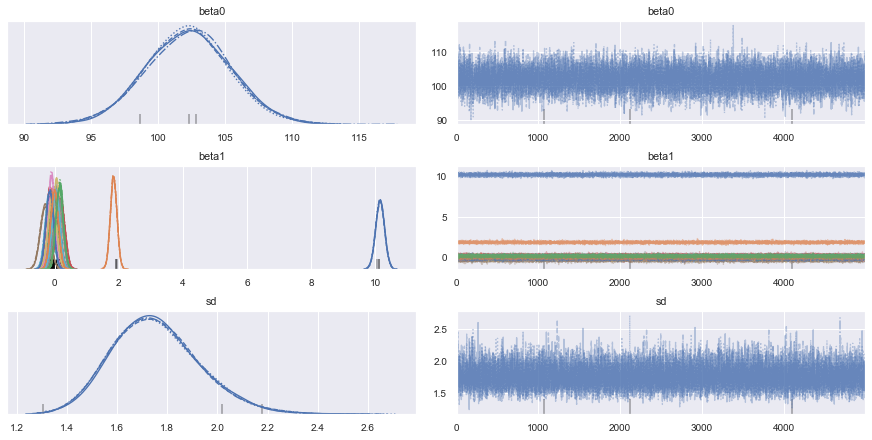

In [9]:
pm.traceplot(hmc_trace)
pm.summary(hmc_trace)

Firstly, note that `Rhat` values (the Gelman Rubin statistic) converging to 1 implies chain convergence for the marginal parameter distributions, while `n_eff` describes the effective number of samples after autocorrelations in the chains have been accounted for. We can see from the `mean` (point) estimate of each parameter that HMC has done a reasonable job of estimating our original parameters.

## Model Inference using Variational Inference (mini-batch ADVI)

Variational Inference (VI) takes a completely different approach to inference. Briefly, VI is a name for a class of algorithms that seek to fit a chosen class of functions to approximate the posterior distribution, effectively turning inference into an optimisation problem. In this instance VI minimises the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) (a measure of the 'similarity' between two densities), between the approximated posterior density and the actual posterior density. An excellent review of VI can be found in the [paper by Blei & co.](https://arxiv.org/abs/1601.00670).

Just to make things more complicated (and for this description to be complete), the KL divergence is actually minimised, by maximising the Evidence Lower BOund (ELBO), which is equal to the negative of the KL divergence up to a constant term - a constant that is computationally infeasible to compute, which is why, technically, we are optimising ELBO and not the KL divergence, albeit to achieve the same end-goal.

We are going to make use of PYMC3's Auto-Differentiation Variational Inference (ADVI) algorithm (full details in the paper by [Kucukelbir & co.](https://arxiv.org/abs/1603.00788)), which is capable of computing a VI for any differentiable posterior distribution (i.e. any model with continuous prior distributions). In order to achieve this very clever feat (the paper is well-worth a read), the algorithm first maps the posterior into a space where all prior distributions have the same support, such that they can be well approximated by fitting a spherical n-dimensional Gaussian distribution within this space - this is referred to as the 'Gaussian mean-field approximation'. Note, that due to the initial transformation, this is **not** the same as approximating the posterior distribution using an n-dimensional Normal distribution. The parameters of these Gaussian parameters are then chosen to maximise the ELBO using gradient ascent - i.e. using high-performance auto-differentiation techniques in numerical computing back-ends such as Theano, TensorFlow, etc..

The assumption of a spherical Gaussian distribution does, however, imply no dependency (i.e. zero correlations) between parameter distributions. One of the advantages of HMC over ADVI, is that these correlations, which can lead to under-estimated variances in the parameter distributions, are included. ADVI gives these up in the name of computational efficiency (i.e. speed and scale of data). This simplifying assumption can be dropped, however, and PYMC3 does offer the option to use 'full-rank' Gaussians, but I have not used this in anger (yet).

We also take the opportunity to make use of PYMC3's ability to compute ADVI using 'batched' data, analogous to how Stochastic Gradient Descent (SGD) is used to optimise loss functions in deep-neural networks, which further facilitates model training at scale thanks to the reliance on auto-differentiation and batched data, which can also be distributed across CPU (or GPUs).

In order to enable mini-batch ADVI, we first have to setup the mini-batches (we use batches of 100 samples).

In [10]:
map_tensor_batch = {y_tensor: pm.Minibatch(train.y.values, 100),
                    x_tensor: pm.Minibatch(x_train.values, 100)}

We then compute the variational inference using 30,000 iterations (for the gradient ascent of the ELBO). We use the `more_replacements` key-word argument to swap-out the original Theano tensors with the batched versions defined above.

In [11]:
with model:
    advi_fit = pm.fit(method=pm.ADVI(), n=30000,
                      more_replacements=map_tensor_batch)    

Average Loss = 550.68: 100%|██████████| 30000/30000 [00:10<00:00, 2800.56it/s]
Finished [100%]: Average Loss = 550.67


Before we take a look at the parameters, let's make sure the ADVI fit has converged by plotting ELBO as a function of the number of iterations.

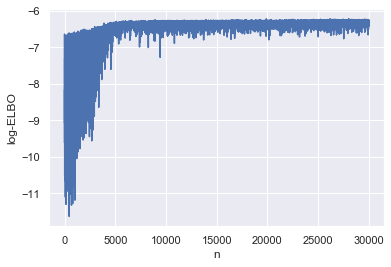

In [12]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

_ = sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In order to be able to look at what we can infer from posterior distribution we have fit with ADVI, we first have to draw some samples from it, before summarising like we did with HMC inference.

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0,1.571,1.788,-1.861,4.816,0.018,0.013,9434.0,9278.0,9440.0,9457.0,NaN
beta1[0],3.505,0.486,2.555,4.365,0.005,0.003,9901.0,9901.0,9908.0,9958.0,NaN
beta1[1],2.440,0.464,1.562,3.293,0.005,0.003,10267.0,10201.0,10258.0,9683.0,NaN
beta1[2],0.765,0.470,-0.124,1.618,0.005,0.003,9850.0,9850.0,9858.0,9838.0,NaN
beta1[3],0.692,0.442,-0.179,1.484,0.004,0.003,10059.0,9937.0,10057.0,9840.0,NaN
beta1[4],1.387,0.469,0.520,2.275,0.005,0.003,9702.0,9702.0,9697.0,9835.0,NaN
beta1[5],1.109,0.456,0.253,1.957,0.005,0.003,10247.0,10247.0,10242.0,9714.0,NaN
beta1[6],1.183,0.475,0.279,2.055,0.005,0.003,9893.0,9893.0,9890.0,9490.0,NaN
beta1[7],1.242,0.458,0.446,2.155,0.005,0.003,9961.0,9961.0,9963.0,9698.0,NaN
beta1[8],1.501,0.467,0.603,2.352,0.005,0.003,9745.0,9566.0,9743.0,9646.0,NaN


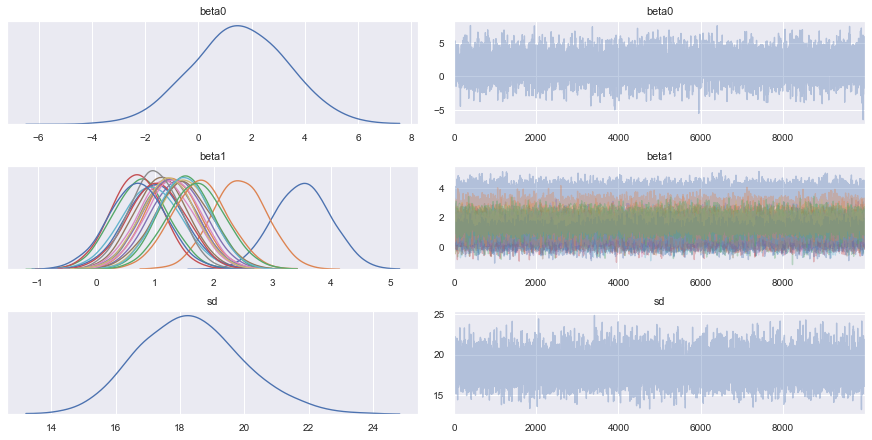

In [13]:
advi_trace = advi_fit.sample(10000)
pm.traceplot(advi_trace)
pm.summary(advi_trace)

Not bad! The mean estimates are comparable, but we note that the standard deviations appear to be larger than those estimated with HMC.

## Comparing Predictions

Let's move on to comparing the inference algorithms on the practical task of making predictions on our test dataset. We start by swapping the test data into our Theano variables.

In [14]:
y_tensor.set_value(test.y.values)
x_tensor.set_value(x_test.values)


And then drawing posterior-predictive samples for each new data-point, for which we use the mean as the point estimate to use for comparison.

  1%|▏         | 13/1000 [00:00<00:08, 114.86it/s]

{'yl': array([[155.03362971, 170.90242824, 173.5968897 , ..., 137.15171178,
        172.15502951, 155.68042891],
       [153.20385551, 175.3239862 , 170.19329938, ..., 138.83530929,
        172.740491  , 162.77040905],
       [152.68744085, 171.05919388, 170.27338061, ..., 133.76234321,
        172.68640134, 157.36345627],
       ...,
       [156.50032494, 175.94077979, 170.3401796 , ..., 139.74205515,
        168.96801298, 161.62905965],
       [150.12176488, 173.96205811, 172.39979898, ..., 137.09121206,
        171.22047792, 158.92306127],
       [158.53362092, 176.1211016 , 171.53449054, ..., 142.27687984,
        170.82159315, 166.27713787]])}


100%|██████████| 1000/1000 [00:10<00:00, 96.74it/s]


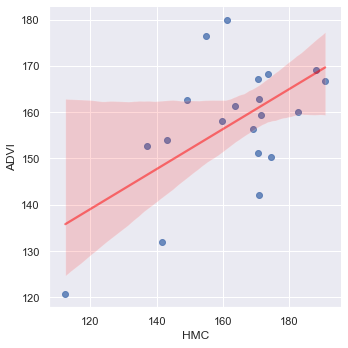

In [15]:
hmc_posterior_pred = pm.sample_posterior_predictive(hmc_trace, 1000, model)
print(hmc_posterior_pred)
hmc_predictions = np.mean(hmc_posterior_pred['yl'], axis=0)

advi_posterior_pred = pm.sample_posterior_predictive(advi_trace, 1000, model)
advi_predictions = np.mean(advi_posterior_pred['yl'], axis=0)

prediction_data = pd.DataFrame(
    {'HMC': hmc_predictions, 
     'ADVI': advi_predictions, 
     'actual': test.y,
     'error_HMC': hmc_predictions - test.y, 
     'error_ADVI': advi_predictions - test.y})

_ = sns.lmplot(y='ADVI', x='HMC', data=prediction_data,
               line_kws={'color': 'red', 'alpha': 0.5})

As we might expect, given the parameter estimates, the two models generate similar predictions. 

To begin to get an insight into the differences between HMC and ADVI, we look at the inferred dependency structure between the samples of `α_0` and `β_0`, for both HMC and VI, starting with HMC.

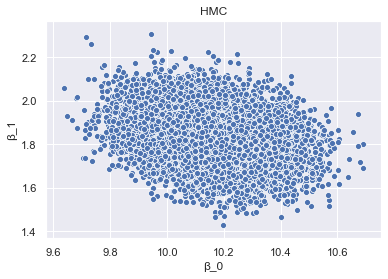

In [16]:
param_samples_HMC = pd.DataFrame(
    {'β_0': hmc_trace.get_values('beta1')[:, 0], 
     'β_1': hmc_trace.get_values('beta1')[:, 1]})

_ = sns.scatterplot(x='β_0', y='β_1', data=param_samples_HMC).set_title('HMC')

And again for ADVI.

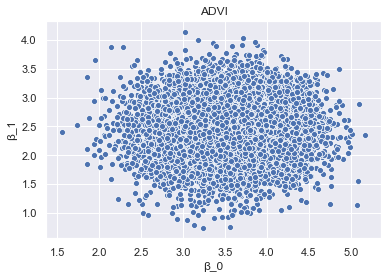

In [17]:
param_samples_ADVI = pd.DataFrame(
    {'β_0': advi_trace.get_values('beta1')[:, 0], 
     'β_1': advi_trace.get_values('beta1')[:, 1]})

_ = sns.scatterplot(x='β_0', y='β_1', data=param_samples_ADVI).set_title('ADVI')

We can see clearly the impact of ADVI's assumption of n-dimensional spherical Gaussians, manifest in the inference!

Finally, let's compare predictions with the actual data.

RMSE for ADVI predictions = 15.931


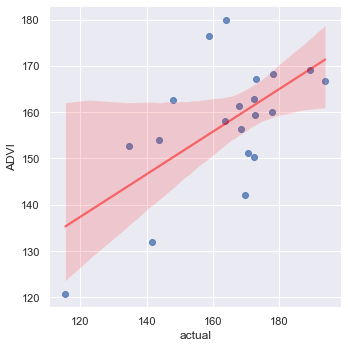

In [18]:
RMSE = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))

print(f'RMSE for ADVI predictions = {RMSE:.3f}')

_ = sns.lmplot(y='ADVI', x='actual', data=prediction_data, 
               line_kws={'color': 'red', 'alpha': 0.5})

Which is what one might expect, given the data generating model.

## Conclusions

MCMC and VI present two very different approaches for drawing inferences from Bayesian models. Despite these differences, their high-level output for a simplistic (but not entirely trivial) regression problem, based on synthetic data, is comparable regardless of the approximations used within ADVI. This is important to note, because general purpose VI algorithms such as ADVI have the potential to work at scale - on large volumes of data in a distributed computing environment (see the references embedded above, for case studies).